# load from synthetic datasets

In [20]:
import os
import argparse

from numpy import linalg
import torch

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as plot_patch
import torch.nn as nn
from torch import optim
import torch.nn.functional as nfunc
import torch.utils.data as data_util
from six.moves import cPickle

In [25]:
%load_ext autoreload
%autoreload 2

from ExpUtils import *
from torch_func.utils import set_framework_seed, weights_init_uniform
from torch_func.evaluate import evaluate_classifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# args

In [23]:
args = argparse.Namespace()
args.alpha = 0.1
args.batch_size = 32
args.beta = 0.66
args.cuda = True
args.data_dir = "/home/xyang2/project/data/dataset"
args.dataset = "1"
args.debug = False
args.device = torch.device('cuda')
args.dir_path = "/home/xyang2/project/runs/L0VAT-semi/syndata-1/ce-lr=1.0-lr_decay=0.995|29627_101000"
args.ent_min = False
args.epoch_decay_start = 80
args.eps = 0.5
args.exp_marker = "ce-lr=1.0-lr_decay=0.995"
args.gamma = -0.1
args.gpu_id = "1"
args.iterations = 1000
args.k = 1
args.kl = 1
args.lamb = 1.0
args.lamb2 = 0.0
args.log_arg = "trainer-lr-lr_decay"
args.log_dir = ""
args.log_interval = 1
args.lr = 1.0
args.lr_a = 1e-06
args.lr_decay = 0.995
args.no_cuda = False
args.resume = ""
args.seed = 1
args.times = 2
args.trainer = "ce"
args.ul_batch_size = 128
args.vis = True
args.xi = 1e-6
args.zeta = 1.1

# model

In [4]:
class MLPSyn(nn.Module):
    def __init__(self, out=2):
        super(MLPSyn, self).__init__()
        self.l1 = nn.Linear(100, 100)
        self.l2 = nn.Linear(100, out)

    def forward(self, h, update_batch_stats=True):
        h = self.l1(h)
        h = nfunc.relu(h)
        h = self.l2(h)
        logits = h
        return logits
    


# load data

07-10 15:22:29: <ipython-input-35-ecce8164c7aa>[77]: error rate 0.04, loss 0.13973


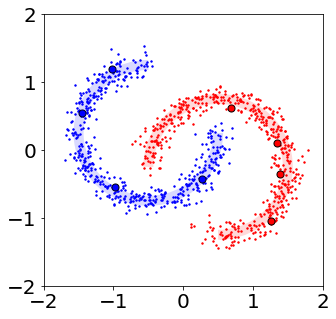

In [58]:
def get_data(args):
    with open('%s/syndata_%s.pkl' % (args.data_dir, args.dataset), "rb") as f:
        if sys.version_info.major == 3:
            dataset = cPickle.load(f, encoding='bytes')
        else:
            dataset = cPickle.load(f)

    # r,b,b,r,b,r,b,r
    index = [1, 2, 3, 4, 7, 8, 10, 13]
    x_train = torch.FloatTensor(np.asarray(dataset[0][0][0][index]))
    t_train = torch.LongTensor(np.asarray(dataset[0][0][1][index]))
    x_valid = torch.FloatTensor(np.asarray(dataset[0][1][0]))
    t_valid = torch.LongTensor(np.asarray(dataset[0][1][1]))

    train_loader = data_util.DataLoader(data_util.TensorDataset(x_train, t_train), 128, False)
    valid_loader = data_util.DataLoader(data_util.TensorDataset(x_valid, t_valid), 128, False)
    return x_train, t_train, x_valid, t_valid, train_loader, valid_loader, dataset

dataset_kit = get_data(args)
x_train, t_train, x_valid, t_valid, train_loader, valid_loader, dataset = dataset_kit
visualize_contour_semi(model, args.dataset, x_train, t_train, x_valid, t_valid, dataset[1], valid_loader, 
                       args, save_filename=None, show_contour=False )

07-10 15:13:07: <ipython-input-35-ecce8164c7aa>[77]: error rate 0.04, loss 0.13973


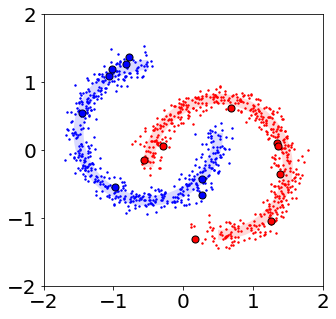

In [48]:
dataset_kit = get_data(args)
x_train, t_train, x_valid, t_valid, train_loader, valid_loader, dataset = dataset_kit
visualize_contour_semi(model, args.dataset, x_train, t_train, x_valid, t_valid, dataset[1], valid_loader, 
                       args, save_filename=None, show_contour=False )

07-10 15:10:27: <ipython-input-35-ecce8164c7aa>[77]: error rate 0.04, loss 0.13973


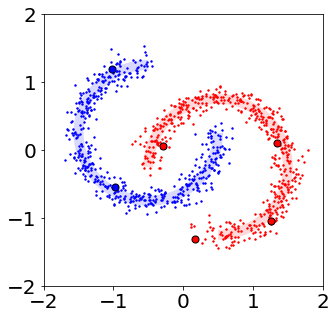

In [42]:
dataset_kit = get_data(args)
x_train, t_train, x_valid, t_valid, train_loader, valid_loader, dataset = dataset_kit
visualize_contour_semi(model, args.dataset, x_train, t_train, x_valid, t_valid, dataset[1], valid_loader, 
                       args, save_filename=None, show_contour=False )

# init model

In [6]:
def init_model(args):
    model = MLPSyn(4 if args.dataset == "3" else 2)
    model.apply(weights_init_uniform)
    model = model.to(args.device)
    generator = None
    if 'ce' == args.trainer:
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
    else:
        optimizer = optim.Adam(model.parameters(), lr=args.lr)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=args.lr_decay)
    return model, optimizer, scheduler

# VAT code

In [21]:
def l2_normalize(d):
    t = d.clone()    # remove from the computing graph
    # norm = torch.sqrt(torch.sum(t.view(d.shape[0], -1) ** 2, dim=1))
    norm = torch.norm(t.view(d.shape[0], -1), p=2, dim=1)
    if len(t.shape) < 1:
        raise NotImplementedError
    # shape [128] -> [128, 1, 1, 1] to match the images' shape [128, c, h, w]
    target_shape = [1] * len(t.shape)
    target_shape[0] = -1
    normed_d = t / (norm.view(target_shape) + 1e-10)
    return normed_d


def entropy(logits):
    p = nfunc.softmax(logits, dim=1)
    return torch.mean(torch.sum(p * nfunc.log_softmax(logits, dim=1), dim=1))


class VAT(object):

    def __init__(self, args):
        self.args = args
        self.device = args.device
        self.xi = args.xi
        self.eps = args.eps
        self.k = args.k
        self.debug = args.debug
        # PyTorch Version difference
        try:
            self.kl_div = nn.KLDivLoss(reduction='none')
        except TypeError:
            self.kl_div = nn.KLDivLoss(size_average=False, reduce=False)
        self.use_ent_min = args.ent_min

    def __call__(self, model, image, kl_way=0):
        logits = model(image, update_batch_stats=False)

        prob_x = nfunc.softmax(logits.detach(), dim=1)
        log_prob_x = nfunc.log_softmax(logits.detach(), dim=1)
        if self.debug:
            # np generator is more controllable than torch.randn(image.size())
            d = np.random.standard_normal(image.size())
            d = l2_normalize(torch.FloatTensor(d).to(self.device))
        else:
            d = torch.randn(image.size(), device=self.args.device)
            d = l2_normalize(d)


        for ip in range(self.k):
            d *= self.xi
            d.requires_grad = True
            t = image.detach()
            x_hat = t + d
            logits_x_hat = model(x_hat, update_batch_stats=False)
            if kl_way == 1:
                prob_x_hat = torch.exp(nfunc.log_softmax(logits_x_hat, dim=1))
                adv_distance = torch.mean(self.kl_div(log_prob_x, prob_x_hat).sum(dim=1))
            else:
                # official theano code compute in this way
                log_prob_x_hat = nfunc.log_softmax(logits_x_hat, dim=1)
                adv_distance = torch.mean(torch.sum(- prob_x * log_prob_x_hat, dim=1))
            # use backward, compute grad on Image and Model weight, use grad, not compute grad on model's weight.
            adv_distance.backward()
            grad_x_hat = d.grad     # / self.xi
            # grad_x_hat = torch.autograd.grad(adv_distance, d)[0]
            # scale it or not, since it will pass through _l2_normalize, but maybe numerical issues
            d = l2_normalize(grad_x_hat).to(self.device)

        logits_x_hat = model(image + self.eps * d, update_batch_stats=False)
        if kl_way == 1:
            prob_x_hat = torch.exp(nfunc.log_softmax(logits_x_hat, dim=1))
            lds = torch.mean(self.kl_div(log_prob_x, prob_x_hat).sum(dim=1))
        else:
            # official theano code works in this way
            log_prob_x_hat = nfunc.log_softmax(logits_x_hat, dim=1)
            lds = torch.mean(torch.sum(- prob_x * log_prob_x_hat, dim=1))

        if self.use_ent_min:
            # if detach_way == 1, the KL divergence contains this part.
            lds += entropy(prob_x)

        return lds

# train code

In [26]:
set_framework_seed(args.seed)

dataset_kit = get_data(args)
model_kit = init_model(args)
x_train, t_train, x_valid, t_valid, train_loader, valid_loader, dataset = dataset_kit
model, optimizer, scheduler = model_kit

err_rate_list = []

reg_component = VAT(args)

criterion = nn.CrossEntropyLoss()

ul_i = 0
loss = 0
error_rate = 1.0
local_best_rate = 100
for i in range(1, args.iterations+1):
    for l_x, l_y in train_loader:
        l_x = l_x.to(args.device)
        l_y = l_y.to(args.device)
        ul_x = torch.FloatTensor(x_valid[ul_i * args.ul_batch_size:ul_i * args.ul_batch_size + args.ul_batch_size]).to(args.device)
        ul_i = 0 if ul_i >= x_valid.shape[0] / args.ul_batch_size - 1 else ul_i + 1
        logits = model(l_x)
        ce_loss = criterion(logits, l_y)
        if "ce" == args.trainer:
            loss = ce_loss
        elif args.trainer == "vat":
            un = reg_component(model, l_x)
            loss = ce_loss + un
        elif args.trainer == "ce-vat":
            un = reg_component(model, ul_x)
            loss = ce_loss + un
        elif "inl0" in args.trainer:
            ul_loss, mask = reg_component(model, ul_x, generator, l0_ins, kl_way=args.kl)
            loss = ce_loss + ul_loss
        else:
            raise NotImplementedError
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if scheduler:
        scheduler.step()

    if i % 10 == 0:
        lr = scheduler.get_lr()[-1]
        test_err, test_loss = evaluate_classifier(model, valid_loader, args.device)
        error_rate = 1.0 * test_err / x_valid.shape[0]
        wlog("iteration %d, train loss %g, test error rate %g and test loss %g" % (i, loss, error_rate, test_loss))
        wlog("lr %g" % lr)
        err_rate_list.append(error_rate)
        if error_rate < local_best_rate:
            local_best_rate = error_rate
        semi_name = "%s/step_%d_%d.jpg" % (args.dir_path, args.seed, i / 10)
        visualize_contour_semi(model, args.dataset, x_train, t_train, x_valid, t_valid, dataset[1], valid_loader, args, save_filename=semi_name)

07-10 10:11:12: <ipython-input-26-2669def9777a>[49]: iteration 10, train loss 0.273421, test error rate 0.169 and test loss 0.344407
07-10 10:11:12: <ipython-input-26-2669def9777a>[50]: lr 0.946355
07-10 10:11:13: <ipython-input-3-04fdbeb64786>[76]: error rate 0.169, loss 0.344407
07-10 10:11:13: <ipython-input-26-2669def9777a>[49]: iteration 20, train loss 0.178947, test error rate 0.117 and test loss 0.318502
07-10 10:11:13: <ipython-input-26-2669def9777a>[50]: lr 0.900087
07-10 10:11:13: <ipython-input-3-04fdbeb64786>[76]: error rate 0.117, loss 0.318502
07-10 10:11:13: <ipython-input-26-2669def9777a>[49]: iteration 30, train loss 0.0390949, test error rate 0.068 and test loss 0.172159
07-10 10:11:13: <ipython-input-26-2669def9777a>[50]: lr 0.856082
07-10 10:11:14: <ipython-input-3-04fdbeb64786>[76]: error rate 0.068, loss 0.172159
07-10 10:11:14: <ipython-input-26-2669def9777a>[49]: iteration 40, train loss 0.00557061, test error rate 0.061 and test loss 0.135032
07-10 10:11:14: <i

07-10 10:11:24: <ipython-input-26-2669def9777a>[49]: iteration 300, train loss 0.000364333, test error rate 0.041 and test loss 0.13754
07-10 10:11:24: <ipython-input-26-2669def9777a>[50]: lr 0.221181
07-10 10:11:24: <ipython-input-3-04fdbeb64786>[76]: error rate 0.041, loss 0.13754
07-10 10:11:24: <ipython-input-26-2669def9777a>[49]: iteration 310, train loss 0.000360325, test error rate 0.041 and test loss 0.137677
07-10 10:11:24: <ipython-input-26-2669def9777a>[50]: lr 0.210367
07-10 10:11:24: <ipython-input-3-04fdbeb64786>[76]: error rate 0.041, loss 0.137677
07-10 10:11:24: <ipython-input-26-2669def9777a>[49]: iteration 320, train loss 0.000356629, test error rate 0.041 and test loss 0.137804
07-10 10:11:24: <ipython-input-26-2669def9777a>[50]: lr 0.200082
07-10 10:11:25: <ipython-input-3-04fdbeb64786>[76]: error rate 0.041, loss 0.137804
07-10 10:11:25: <ipython-input-26-2669def9777a>[49]: iteration 330, train loss 0.000353202, test error rate 0.041 and test loss 0.137905
07-10 1

07-10 10:11:34: <ipython-input-26-2669def9777a>[49]: iteration 590, train loss 0.000310287, test error rate 0.04 and test loss 0.139319
07-10 10:11:34: <ipython-input-26-2669def9777a>[50]: lr 0.0516941
07-10 10:11:34: <ipython-input-3-04fdbeb64786>[76]: error rate 0.04, loss 0.139319
07-10 10:11:35: <ipython-input-26-2669def9777a>[49]: iteration 600, train loss 0.000309601, test error rate 0.04 and test loss 0.139344
07-10 10:11:35: <ipython-input-26-2669def9777a>[50]: lr 0.0491668
07-10 10:11:35: <ipython-input-3-04fdbeb64786>[76]: error rate 0.04, loss 0.139344
07-10 10:11:35: <ipython-input-26-2669def9777a>[49]: iteration 610, train loss 0.00030899, test error rate 0.04 and test loss 0.139367
07-10 10:11:35: <ipython-input-26-2669def9777a>[50]: lr 0.046763
07-10 10:11:35: <ipython-input-3-04fdbeb64786>[76]: error rate 0.04, loss 0.139367
07-10 10:11:36: <ipython-input-26-2669def9777a>[49]: iteration 620, train loss 0.000308335, test error rate 0.04 and test loss 0.139388
07-10 10:11

07-10 10:11:44: <ipython-input-26-2669def9777a>[49]: iteration 880, train loss 0.000299886, test error rate 0.04 and test loss 0.13968
07-10 10:11:44: <ipython-input-26-2669def9777a>[50]: lr 0.0120819
07-10 10:11:44: <ipython-input-3-04fdbeb64786>[76]: error rate 0.04, loss 0.13968
07-10 10:11:45: <ipython-input-26-2669def9777a>[49]: iteration 890, train loss 0.000299707, test error rate 0.04 and test loss 0.139685
07-10 10:11:45: <ipython-input-26-2669def9777a>[50]: lr 0.0114912
07-10 10:11:45: <ipython-input-3-04fdbeb64786>[76]: error rate 0.04, loss 0.139685
07-10 10:11:45: <ipython-input-26-2669def9777a>[49]: iteration 900, train loss 0.000299588, test error rate 0.04 and test loss 0.13969
07-10 10:11:45: <ipython-input-26-2669def9777a>[50]: lr 0.0109294
07-10 10:11:45: <ipython-input-3-04fdbeb64786>[76]: error rate 0.04, loss 0.13969
07-10 10:11:45: <ipython-input-26-2669def9777a>[49]: iteration 910, train loss 0.000299454, test error rate 0.04 and test loss 0.139695
07-10 10:11:4

07-10 10:25:12: <ipython-input-35-ecce8164c7aa>[77]: error rate 0.04, loss 0.13973


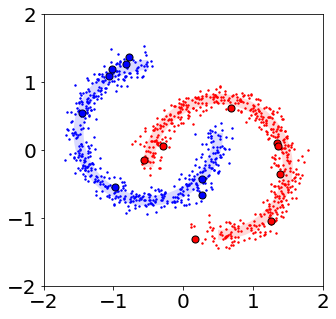

In [36]:
visualize_contour_semi(model, args.dataset, x_train, t_train, x_valid, t_valid, dataset[1], valid_loader, 
                       args, save_filename=None, show_contour=False )

# visualize

In [ ]:
def visualize_contour(model, d_i, x_data, y_data, basis, val_loader, args, with_lds=False, save_filename='prob_cont', show_contour=True):
    line_width = 10

    range_x = np.arange(-2.0, 2.1, 0.05)
    a_inv = linalg.inv(np.dot(basis, basis.T))
    train_x_org = np.dot(x_data, np.dot(basis.T, a_inv))
    test_x_org = np.zeros((range_x.shape[0] ** 2, 2))
    train_x_1_ind = np.where(y_data == 1)[0]
    train_x_0_ind = np.where(y_data == 0)[0]

    for t in range(range_x.shape[0]):
        for j in range(range_x.shape[0]):
            test_x_org[range_x.shape[0] * t + j, 0] = range_x[t]
            test_x_org[range_x.shape[0] * t + j, 1] = range_x[j]

    test_x = np.dot(test_x_org, basis)
    model.eval()
    f_p_y_given_x = model(torch.FloatTensor(test_x).to(args.device))
    pred = nfunc.softmax(f_p_y_given_x, dim=1)[:, 1].cpu().detach().numpy()

    z = np.zeros((range_x.shape[0], range_x.shape[0]))
    for t in range(range_x.shape[0]):
        for j in range(range_x.shape[0]):
            z[t, j] = pred[range_x.shape[0] * t + j]

    y, x = np.meshgrid(range_x, range_x)

    font_size = 20
    rc = 'r'
    bc = 'b'

    if d_i == "1":
        rescale = 1.0  # /np.sqrt(500)
        arc1 = plot_patch.Arc(xy=(0.5 * rescale, -0.25 * rescale), width=2.0 * rescale, height=2.0 * rescale, angle=0, theta1=270,
                              theta2=180, linewidth=line_width, alpha=0.15, color=rc)
        arc2 = plot_patch.Arc(xy=(-0.5 * rescale, +0.25 * rescale), width=2.0 * rescale, height=2.0 * rescale, angle=0, theta1=90,
                              theta2=360, linewidth=line_width, alpha=0.15, color=bc)
        fig = plt.gcf()
        fig.gca().add_artist(arc1)
        fig.gca().add_artist(arc2)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
    else:
        rescale = 1.0  # /np.sqrt(500)
        circle1 = plot_patch.Circle((0, 0), 1.0 * rescale, color=rc, alpha=0.2, fill=False, linewidth=line_width)
        circle2 = plot_patch.Circle((0, 0), 0.15 * rescale, color=bc, alpha=0.2, fill=False, linewidth=line_width)
        fig = plt.gcf()
        fig.gca().add_artist(circle1)
        fig.gca().add_artist(circle2)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)

    levels = [0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]
    cs = plt.contour(x * rescale, y * rescale, z, 7, cmap='bwr', vmin=0., vmax=1.0, linewidths=8., levels=levels)
    color_bar = plt.colorbar(cs)
    color_bar.ax.tick_params(labelsize=font_size)
    plt.setp(cs.collections, linewidth=1.0)
    plt.contour(x * rescale, y * rescale, z, 1, cmap='binary', vmin=0, vmax=0.5, linewidths=2.0)

    plt.xlim([-2. * rescale, 2. * rescale])
    plt.ylim([-2. * rescale, 2. * rescale])
    plt.xticks([-2.0, -1.0, 0, 1, 2.0], fontsize=font_size)
    plt.yticks([-2.0, -1.0, 0, 1, 2.0], fontsize=font_size)

    plt.scatter(train_x_org[train_x_1_ind, 0] * rescale, train_x_org[train_x_1_ind, 1] * rescale, s=10, marker='o', c=rc, label='$y=1$')
    plt.scatter(train_x_org[train_x_0_ind, 0] * rescale, train_x_org[train_x_0_ind, 1] * rescale, s=10, marker='^', c=bc, label='$y=0$')

    err_num, loss = evaluate_classifier(model, val_loader, args.device)
    err_rate = 1.0 * err_num / len(val_loader.dataset)
    wlog("error and loss  %g, %g" % (err_num, loss))
    wlog("error rate %g" % err_rate)

    lds_part = ""
    if with_lds:
        args.eps = 0.5
        args.k = 5
        reg_component = VAT(args)
        x_data = x_data.to(args.device)

        avg_lds = 0
        for t in range(20):
            avg_lds = reg_component(model, x_data, kl_way=1)
        avg_lds /= 20
        lds_part = '\nAverage $\widetilde{\\rm LDS}=%.3f$' % avg_lds
        args.k = 1
    if show_contour:
        plt.title('%s Error %g%s' % (args.trainer, err_rate, lds_part))
    fig.set_size_inches(5, 5)
    if save_filename is None:
        plt.show(block=False)
    else:
        plt.savefig(save_filename)
    plt.close()


# vis two

In [35]:
def visualize_contour_semi(model, d_i, x_data, y_data, ul_x, ul_y, basis, val_loader, args, with_lds=True, save_filename='prob_cont', show_contour=True):
    line_width = 10

    range_x = np.arange(-2.0, 2.1, 0.05)
    a_inv = linalg.inv(np.dot(basis, basis.T))
    train_x_org = np.dot(x_data, np.dot(basis.T, a_inv))
    test_x_org = np.zeros((range_x.shape[0] ** 2, 2))
    train_x_1_ind = np.where(y_data == 1)[0]
    train_x_0_ind = np.where(y_data == 0)[0]

    ul_x_org = np.dot(ul_x, np.dot(basis.T, a_inv))
    ul_x_1_ind = np.where(ul_y == 1)[0]
    ul_x_0_ind = np.where(ul_y == 0)[0]

    for i in range(range_x.shape[0]):
        for j in range(range_x.shape[0]):
            test_x_org[range_x.shape[0] * i + j, 0] = range_x[i]
            test_x_org[range_x.shape[0] * i + j, 1] = range_x[j]

    test_x = np.dot(test_x_org, basis)
    model.eval()
    f_p_y_given_x = model(torch.FloatTensor(test_x).to(args.device))
    pred = nfunc.softmax(f_p_y_given_x, dim=1)[:, 1].cpu().detach().numpy()

    z = np.zeros((range_x.shape[0], range_x.shape[0]))
    for i in range(range_x.shape[0]):
        for j in range(range_x.shape[0]):
            z[i, j] = pred[range_x.shape[0] * i + j]

    y, x = np.meshgrid(range_x, range_x)

    font_size = 20
    rc = 'r'
    bc = 'b'

    if d_i == "1":
        rescale = 1.0  # /np.sqrt(500)
        arc1 = plot_patch.Arc(xy=(0.5 * rescale, -0.25 * rescale), width=2.0 * rescale, height=2.0 * rescale, angle=0, theta1=270,
                              theta2=180, linewidth=line_width, alpha=0.15, color=rc)
        arc2 = plot_patch.Arc(xy=(-0.5 * rescale, +0.25 * rescale), width=2.0 * rescale, height=2.0 * rescale, angle=0, theta1=90,
                              theta2=360, linewidth=line_width, alpha=0.15, color=bc)
        fig = plt.gcf()
        fig.gca().add_artist(arc1)
        fig.gca().add_artist(arc2)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
    else:
        rescale = 1.0  # /np.sqrt(500)
        circle1 = plot_patch.Circle((0, 0), 1.0 * rescale, color=rc, alpha=0.2, fill=False, linewidth=line_width)
        circle2 = plot_patch.Circle((0, 0), 0.15 * rescale, color=bc, alpha=0.2, fill=False, linewidth=line_width)
        fig = plt.gcf()
        fig.gca().add_artist(circle1)
        fig.gca().add_artist(circle2)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)

    if show_contour:
        levels = [0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]
        cs = plt.contour(x * rescale, y * rescale, z, 7, cmap='bwr', vmin=0., vmax=1.0, linewidths=8., levels=levels)
        color_bar = plt.colorbar(cs)
        color_bar.ax.tick_params(labelsize=font_size)
        plt.setp(cs.collections, linewidth=1.0)
        plt.contour(x * rescale, y * rescale, z, 1, cmap='binary', vmin=0, vmax=0.5, linewidths=2.0)

    plt.xlim([-2. * rescale, 2. * rescale])
    plt.ylim([-2. * rescale, 2. * rescale])
    plt.xticks([-2.0, -1.0, 0, 1, 2.0], fontsize=font_size)
    plt.yticks([-2.0, -1.0, 0, 1, 2.0], fontsize=font_size)

    plt.scatter(ul_x_org[ul_x_1_ind, 0] * rescale, ul_x_org[ul_x_1_ind, 1] * rescale, s=2, marker='o', c=rc, label='$y=1$')
    plt.scatter(ul_x_org[ul_x_0_ind, 0] * rescale, ul_x_org[ul_x_0_ind, 1] * rescale, s=2, marker='o', c=bc, label='$y=0$')
    plt.scatter(train_x_org[train_x_1_ind, 0] * rescale, train_x_org[train_x_1_ind, 1] * rescale, s=50, marker='o', c=rc, label='$y=1$', edgecolor='black', linewidth=1)
    plt.scatter(train_x_org[train_x_0_ind, 0] * rescale, train_x_org[train_x_0_ind, 1] * rescale, s=50, marker='o', c=bc, label='$y=0$', edgecolor='black', linewidth=1)

    err_num, loss = evaluate_classifier(model, val_loader, args.device)
    err_rate = 1.0 * err_num / len(val_loader.dataset)
    wlog("error rate %g, loss %g" % (err_rate, loss))

    lds_part = ""
    if with_lds:
        args.eps = 0.5
        args.k = 5
        reg_component = VAT(args)
        x_data = x_data.to(args.device)

        ave_lds = 0
        for t in range(20):
            ave_lds += reg_component(model, x_data, kl_way=1)
        ave_lds /= 20
        lds_part = ' $\widetilde{\\rm LDS}=%.3f$' % ave_lds
        args.k = 1
    if show_contour:
        plt.title('%s\nError %g%s' % (args.exp_marker, err_rate, lds_part))
    fig.set_size_inches(5, 5)
    if save_filename is None:
        plt.show()
    else:
        plt.savefig(save_filename)
    plt.close()

